# **Introduction**
This project aims to predict 1-hour EURUSD exchange rates using a sophisticated combination of deep learning techniques. The process begins with meticulous data preparation, involving formatting and Min-Max scaling for optimal model convergence. Technical indicators such as RSI, MA, EMA, and VWAP are calculated, enriching the model's understanding of market dynamics. The model architecture integrates LSTM cells, self-attention mechanisms, and 1D convolutional layers to capture intricate temporal patterns. TensorFlow is employed for implementation, allowing for customization and flexibility. The training phase involves hyperparameter experimentation and continuous monitoring, while evaluation utilizes metrics like MSE and MAE. The trained model is deployed for predicting unseen data, and visualizations aid in analyzing performance patterns and guiding refinements. Ultimately, this project seeks to leverage deep learning for nuanced insights into short-term EURUSD fluctuations in the dynamic financial landscape.


---




1. **Data Preparation:**
   - Ensuring the right format for time-series data is crucial.
   - Mapping the data to a range between -1 and 1 using Min-Max scaling is a good normalization approach.
   - Splitting data into training, testing, and possibly validation sets sets the foundation for model evaluation.

2. **Calculate Indicators:**
   - Adding indicators like RSI, MA (Moving Average), EMA (Exponential Moving Average), and VWAP (Volume Weighted Average Price) can provide valuable input features for your model.

3. **Model Architecture:**
   - Stacking multiple LSTM cells enhances the model's ability to capture complex patterns over time.
   - Implementing self-attention mechanisms helps the model focus on specific time steps, allowing for more flexibility in capturing dependencies.
   - 1D convolutional layers contribute to identifying local patterns and short-term dependencies.

4. **Implementation:**
   - Using TensorFlow or another deep learning framework gives you flexibility and community support.
   - Customizing layers or functions for attention mechanisms may involve diving into the details of your chosen framework.

5. **Training:**
   - Experimenting with hyperparameters like learning rates, batch sizes, and epochs is essential for finding the optimal training setup.
   - Monitoring training performance using metrics such as training loss and validation loss ensures your model is learning effectively.
   - Implementing early stopping helps prevent overfitting and improves generalization.

6. **Evaluation:**
   - A variety of evaluation metrics, including MSE, MAE, and R-squared, provides a comprehensive assessment of your model's performance.

7. **Prediction:**
   - Deploying your trained model to make predictions on unseen data is the ultimate test of its effectiveness.

8. **Visualization:**
   - Plotting predicted values against actual values allows for a visual inspection of your model's performance.
   - Analyzing patterns or discrepancies can guide further refinements to your model.

It looks like you've got a thorough and well-thought-out plan. As you go through each step, feel free to reach out if you have questions or need assistance with any specific aspect of the process. Good luck with your project!

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, RepeatVector, Permute, multiply, Activation, Lambda, concatenate, Flatten, BatchNormalization, Bidirectional, TimeDistributed, Wrapper
from tensorflow.keras import activations
from tensorflow.keras import backend as K
import keras
from sklearn import preprocessing




Mounted at /content/drive


# **1. Load Data**
In this snippet of code, the pandas library is employed to load a dataset from a CSV file containing hourly EURUSD (Euro to US Dollar) exchange rate information. The columns, initially labeled generically, are aptly renamed to 'Time', 'Open', 'Low', 'High', 'Close', and 'Volume' for clarity. The 'Time' column is then converted to datetime format, facilitating temporal analyses. The financial data is subsequently extracted into separate arrays for 'Close', 'Open', 'High', and 'Low' prices, each formatted appropriately for potential utilization in subsequent data analysis or machine learning modeling. This meticulous data loading process establishes a foundational step for the exploration and potential prediction of EURUSD exchange rate dynamics.

In [7]:
data_df = pd.read_csv('/content/drive/MyDrive/EURUSD_H1.csv')

data_df.columns = ['Time', 'Open', 'Low', 'High', 'Close', 'Volume']

data_close = data_df['Close'].to_numpy()
data_open = data_df['Open'].to_numpy().reshape(-1,1)
data_high = data_df['High'].to_numpy().reshape(-1,1)
data_low = data_df['Low'].to_numpy().reshape(-1,1)
data_df['Time'] = pd.to_datetime(data_df['Time'])


In [8]:
data_df = data_df.drop('Time', axis=1)

# **2. Feature Engineering for EURUSD Time-Series Analysis**


In this code segment, a comprehensive set of features is engineered to enhance the analysis of hourly EURUSD exchange rate data. The process involves the calculation of various indicators and deltas using different window sizes. RSI (Relative Strength Index), Moving Averages (MA), Rolling Standard Deviations, Exponential Moving Averages (EMA), Rolling Minimums, and Rolling Maximums are computed over specified window sizes, providing nuanced insights into the underlying market trends. Additionally, Delta values for 'high', 'low', 'close', and 'open' columns are computed, capturing the rate of change over different time periods. The Volume Weighted Average Price (VWAP) is also calculated, offering a volume-weighted perspective on the average price. Finally, rows with N/A values are dropped to ensure a clean dataset for subsequent analysis. This meticulous feature engineering process lays the groundwork for more sophisticated modeling and predictive analyses of the EURUSD exchange rate dynamics.

In [9]:
# Define window sizes
window_sizes = [3, 6, 9, 12, 14, 18, 24]

# Calculate RSI
def calculate_rsi(df, column='Close', window=14):
    df['delta'] = df[column].diff()
    df['gain'] = df['delta'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['delta'].apply(lambda x: abs(x) if x < 0 else 0)
    avg_gain = df['gain'].rolling(window=window).mean()
    avg_loss = df['loss'].rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['rsi'] = rsi
    df.drop(['delta', 'gain', 'loss'], axis=1, inplace=True)

window_sizes1 = [1, 2, 3, 6, 9, 12, 14, 18, 24]

# Calculate Delta for 'high', 'low', 'close', and 'open' columns
for window in window_sizes1:
    # Calculate Delta for 'high'
    data_df[f'high_delta_{window}'] = data_df['High'].diff(periods=window)

    # Calculate Delta for 'low'
    data_df[f'low_delta_{window}'] = data_df['Low'].diff(periods=window)

    # Calculate Delta for 'close'
    data_df[f'close_delta_{window}'] = data_df['Close'].diff(periods=window)

    # Calculate Delta for 'open'
    data_df[f'open_delta_{window}'] = data_df['Open'].diff(periods=window)


window_sizes = [3, 6, 9, 12, 14, 18, 24]

# Calculate indicators for different window sizes
for window in window_sizes:
    # Calculate RSI
    calculate_rsi(data_df, window=window)

    # Calculate MA
    data_df[f'ma_{window}'] = data_df['Close'].rolling(window=window).mean()

    # Calculate Rolling Standard Deviation
    data_df[f'rolling_std_{window}'] = data_df['Close'].rolling(window=window).std()

    # Calculate EMA
    data_df[f'ema_{window}'] = data_df['Close'].ewm(span=window, adjust=False).mean()

    # Calculate Rolling Minimum
    data_df[f'rolling_min_{window}'] = data_df['Close'].rolling(window=window).min()

    # Calculate Rolling Maximum
    data_df[f'rolling_max_{window}'] = data_df['Close'].rolling(window=window).max()

# Calculate VWAP for a specific window size (e.g., 12)
data_df['vwap'] = (data_df['Close'] * data_df['Volume']).cumsum() / data_df['Volume'].cumsum()

# Drop rows with N/A values
data_df = data_df.dropna()

# Display the DataFrame with the calculated indicators
data_df

,Open,Low,High,Close,Volume,high_delta_1,low_delta_1,close_delta_1,open_delta_1,high_delta_2,...,rolling_std_18,ema_18,rolling_min_18,rolling_max_18,ma_24,rolling_std_24,ema_24,rolling_min_24,rolling_max_24,vwap
24,1.35900,1.35940,1.35735,1.35755,35605,-0.00110,-0.00010,-0.00145,-0.00040,-0.00185,...,0.001359,1.359222,1.35725,1.36150,1.359216,0.001341,1.359206,1.35710,1.36150,1.358794
25,1.35755,1.35830,1.35605,1.35740,67881,-0.00130,-0.00110,-0.00015,-0.00145,-0.00240,...,0.001413,1.359030,1.35725,1.36150,1.359147,0.001391,1.359061,1.35710,1.36150,1.358724
26,1.35740,1.35890,1.35740,1.35830,45973,0.00135,0.00060,0.00090,-0.00015,0.00005,...,0.001412,1.358953,1.35725,1.36150,1.359110,0.001402,1.359000,1.35710,1.36150,1.358710
27,1.35825,1.36010,1.35815,1.35950,44258,0.00075,0.00120,0.00120,0.00085,0.00210,...,0.001385,1.359011,1.35725,1.36150,1.359056,0.001358,1.359040,1.35710,1.36150,1.358734
28,1.35950,1.36030,1.35915,1.35950,40872,0.00100,0.00020,0.00000,0.00125,0.00175,...,0.001354,1.359062,1.35725,1.36150,1.358997,0.001304,1.359077,1.35710,1.36150,1.358755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,1.06886,1.06886,1.06805,1.06825,12951,-0.00066,-0.00035,-0.00062,-0.00020,-0.00041,...,0.001055,1.067625,1.06498,1.06905,1.066907,0.002013,1.067090,1.06242,1.06905,1.265842
99995,1.06826,1.06917,1.06744,1.06905,18399,-0.00061,0.00031,0.00080,-0.00060,-0.00127,...,0.000798,1.067775,1.06593,1.06905,1.067082,0.002009,1.067247,1.06242,1.06905,1.265840
99996,1.06900,1.06943,1.06697,1.06756,22377,-0.00047,0.00026,-0.00149,0.00074,-0.00108,...,0.000604,1.067752,1.06709,1.06905,1.067191,0.001959,1.067272,1.06242,1.06905,1.265836
99997,1.06756,1.06784,1.06582,1.06624,23764,-0.00115,-0.00159,-0.00132,-0.00144,-0.00162,...,0.000745,1.067593,1.06624,1.06905,1.067291,0.001838,1.067190,1.06242,1.06905,1.265832



# **3.Preprocessing**

This code segment focuses on the preparation of time series data tailored for Long Short-Term Memory (LSTM) modeling, a key step in forecasting EURUSD exchange rate dynamics. The function `prepare_time_series_data` takes the input data and configures it into sequences of time steps, with each sequence capturing past observations. Utilizing MinMaxScaler for normalization, the data is scaled to a range between -1 and 1. The resulting dataset is then split into input sequences (`X`) and corresponding target values (`y`). These sequences, representing historical patterns, are crucial for training the LSTM model effectively. Subsequently, the training and testing sets are further split, facilitating model evaluation. The print statements offer insights into the shapes of the training and testing sets, providing a concise overview of the prepared data structure. The final variable, `features`, signifies the number of input features considered for each time step, a fundamental parameter in the subsequent LSTM architecture. Overall, this process establishes a well-prepared temporal dataset for training and evaluating LSTM models in the context of EURUSD hourly exchange rate prediction.

In [10]:
data_numpy = data_df.to_numpy()
time_steps = 12

x_train, x_test, y_train, y_test = train_test_split(data_numpy, data_numpy[:, 3], test_size=0.2, random_state=42, shuffle=False)

# Fit the MinMaxScaler on the training data
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train)

# Transform the test data using the same scaler
x_test_scaled = min_max_scaler.transform(x_test)

X_train, Y_train = [], []
X_test, Y_test = [], []

for i in range(time_steps, len(x_train_scaled)):
        X_train.append(x_train_scaled[i - 12:i, :])
        Y_train.append(x_train_scaled[i,3])

for i in range(time_steps, len(x_test_scaled)):
        X_test.append(x_test_scaled[i - 12:i, :])
        Y_test.append(x_test_scaled[i,3])

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print("Updated training set shapes:")
print(X_train.shape, Y_train.shape)

print("\nUpdated testing set shapes:")
print(X_test.shape, Y_test.shape)

features = X_train.shape[2]


Updated training set shapes:
(79968, 12, 78) (79968,)

Updated testing set shapes:
(19983, 12, 78) (19983,)


# **4. Attention-based LSTM-CNN Model for EURUSD Prediction**

This code defines a sophisticated neural network architecture combining Bidirectional Long Short-Term Memory (BiLSTM), self-attention, and Convolutional Neural Network (CNN) layers for predicting EURUSD exchange rates. The input shape is established based on the predefined time steps and features, reflecting the temporal nature of the data. The BiLSTM layers capture intricate temporal dependencies, while a masking layer ensures attention mechanisms exclude padding. The self-attention layer focuses on relevant time steps, enhancing the model's adaptability. Simultaneously, a CNN layer captures local patterns in the data. The TimeDistributed Dense layer processes the CNN output, and both the attention and CNN layers are concatenated. The architecture is completed with fully connected layers, culminating in an output layer for predicting the 1-hour EURUSD exchange rate. This multifaceted model is designed to capture both sequential and local patterns, offering a robust framework for accurate and nuanced predictions in the dynamic foreign exchange market. The model summary provides a comprehensive overview of the network's structure and parameters, highlighting its complexity and potential predictive power.

In [11]:
from keras.backend import flatten
from keras.layers import Input, Dense, LSTM, Bidirectional, Activation, Lambda, RepeatVector, Permute, multiply, Conv1D, concatenate, Masking
from tensorflow.keras.layers import Reshape

# Define the input shape
inputs = Input(shape=(time_steps, features))

# BiLSTM layer
Unit_LSTM = 32
lstm_output = Bidirectional(LSTM(units=Unit_LSTM*2, activation='tanh', return_sequences=True))(inputs)
lstm_output = Bidirectional(LSTM(units=Unit_LSTM, activation='tanh', return_sequences=True))(lstm_output)

# Masking layer to exclude padding from attention
masking_layer = Masking(mask_value=0.0)(inputs)

# Self-Attention Layer
attention = Dense(Unit_LSTM, activation='tanh')(lstm_output)
attention = Dense(1)(attention)
attention = Activation('softmax', name='attention_weights')(attention)
attention = Lambda(lambda x: x[:, :, 0])(attention)
attention = RepeatVector(Unit_LSTM*2)(attention)
attention = Permute([2, 1])(attention)
attention = multiply([lstm_output, attention])
attention = Lambda(lambda x: keras.backend.sum(x, axis=1))(attention)

# CNN Layer
cnn_output = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(masking_layer)
cnn_output = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn_output)

# TimeDistributed Dense layer
dense_output = TimeDistributed(Dense(32, activation='relu'))(cnn_output)
cnn_output_reshaped = Reshape((-1,))(dense_output)

# Concatenate CNN and Attention layers
merged_output = concatenate([attention, cnn_output_reshaped], axis=-1)

# Add output layer
fc_layer = Dense(units=16, activation='relu')(merged_output)
output_layer = Dense(units=1, activation='linear')(fc_layer)

# Define the model
model = Model(inputs=inputs, outputs=output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 78)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 12, 128)              73216     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 12, 64)               41216     ['bidirectional[0][0]']       
 onal)                                                                                            
                                                                                              

This code segment orchestrates the training process of the previously defined multimodal neural network architecture for predicting 1-hour EURUSD exchange rates. Utilizing Keras callbacks, the ModelCheckpoint ensures that the best-performing model weights are saved during training, based on the validation loss. A custom R-squared metric function is implemented, complementing Mean Squared Error and Mean Absolute Error metrics, and the model is compiled with the Adam optimizer and a specified learning rate.

The training process unfolds over 50 epochs, with a batch size of 64. Throughout training, the model's performance is monitored, and the best weights are saved for later use. The provided validation data (X_test, y_test) allows for the assessment of the model's generalization to unseen data. The verbose parameter enables detailed progress updates during training.

This comprehensive training and evaluation process establishes the neural network's ability to learn from the provided data, fine-tuning its parameters to optimize predictions of 1-hour EURUSD exchange rates. The inclusion of custom metrics and model checkpointing enhances the model's interpretability and ensures the retention of optimal weights for future deployment and analysis.

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
]

import keras.backend as K

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)


history = model.fit(
    X_train,
    Y_train,
    batch_size=64,
    epochs=50,
    callbacks=callbacks,validation_data=(X_test,Y_test),
    verbose=1,
)

Epoch 1/50
1250/1250 [==============================] - 30s 17ms/step - loss: 2.6882e-04 - mae: 0.0090 - r_squared: 0.9988 - val_loss: 2.7367e-04 - val_mae: 0.0109 - val_r_squared: -1.4781
Epoch 2/50
1250/1250 [==============================] - 18s 15ms/step - loss: 8.5266e-05 - mae: 0.0068 - r_squared: 0.9996 - val_loss: 6.4397e-04 - val_mae: 0.0217 - val_r_squared: -6.9206
Epoch 3/50
1250/1250 [==============================] - 20s 16ms/step - loss: 8.3112e-05 - mae: 0.0067 - r_squared: 0.9996 - val_loss: 2.5691e-04 - val_mae: 0.0115 - val_r_squared: -1.5794
Epoch 4/50
1250/1250 [==============================] - 19s 15ms/step - loss: 7.2039e-05 - mae: 0.0062 - r_squared: 0.9997 - val_loss: 9.3649e-05 - val_mae: 0.0060 - val_r_squared: 0.1429
Epoch 5/50
1250/1250 [==============================] - 19s 15ms/step - loss: 3.6526e-04 - mae: 0.0078 - r_squared: 0.9983 - val_loss: 2.1600e-04 - val_mae: 0.0103 - val_r_squared: -1.1180
Epoch 6/50
1250/1250 [==============================] - 

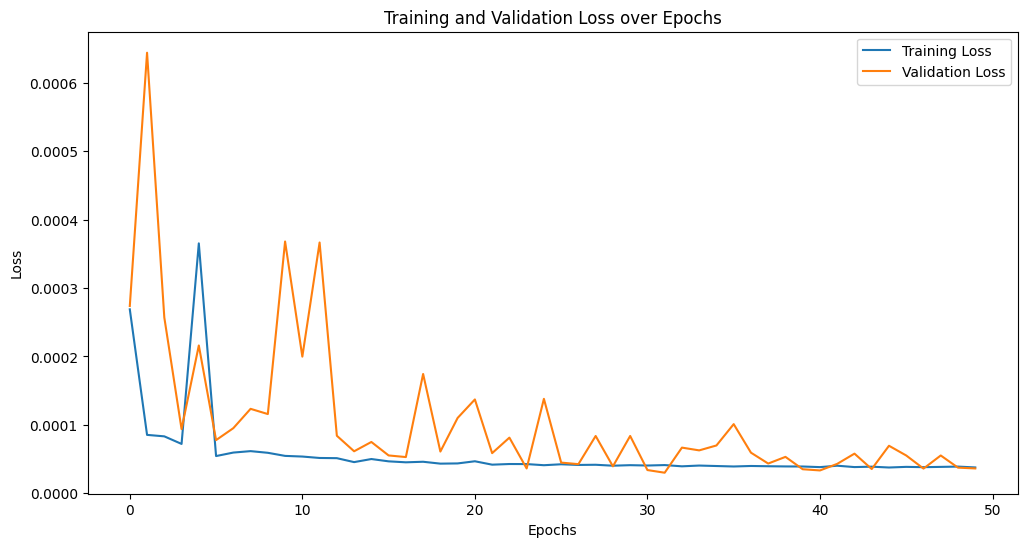

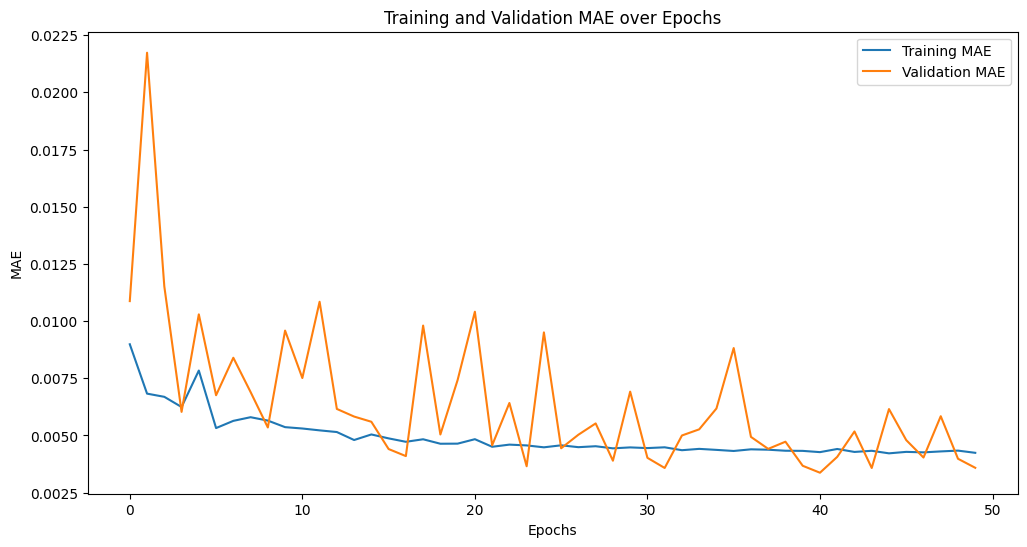

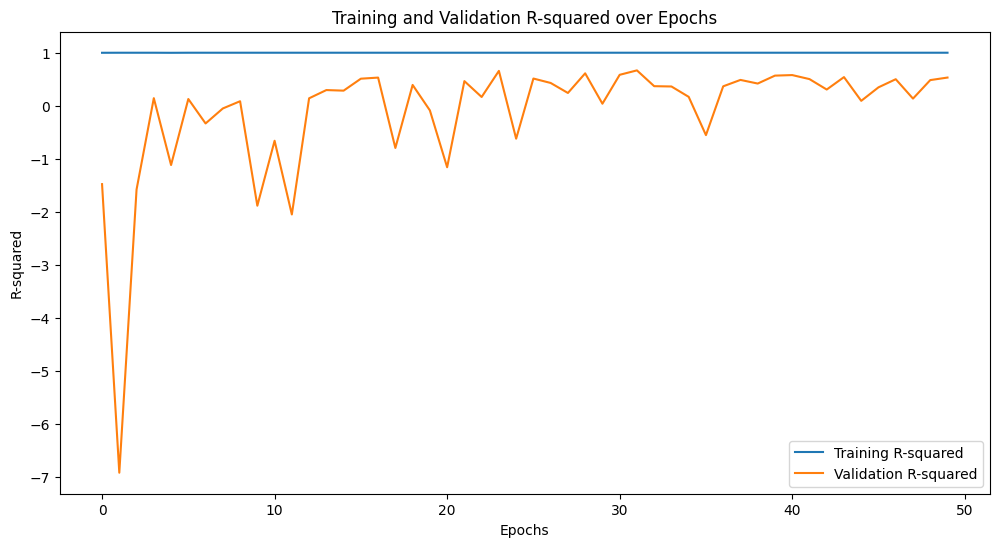

In [14]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable containing the training history

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Mean Absolute Error (MAE)
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plotting R-squared
plt.figure(figsize=(12, 6))
plt.plot(history.history['r_squared'], label='Training R-squared')
plt.plot(history.history['val_r_squared'], label='Validation R-squared')
plt.title('Training and Validation R-squared over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.legend()
plt.show()


# **5. Model Evaluation and Visualization**

This code segment executes a comprehensive evaluation of a trained regression model designed for predicting 1-hour EURUSD exchange rates. The `evaluate_and_plot_regression_model` function systematically assesses the model's performance on both training and testing datasets, providing key metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Median Absolute Error, Explained Variance Score, and R-squared. Additionally, the predictions are transformed back to the original scale for a more interpretable analysis.

The function proceeds to plot predictions against actual values, showcasing the model's accuracy in capturing both the initial and final 200 observations. Visualizing the last 1000 predictions versus targets offers a more extensive perspective on the model's performance over a larger dataset. This multi-faceted evaluation and visualization process provides valuable insights into the model's predictive capabilities and helps identify potential areas for improvement or fine-tuning.

625/625 [==============================] - 5s 5ms/step
MAE of Train Dataset = 12.013937971679892 pip
MAE of Test Dataset = 11.577313959581998 pip
Mean absolute error = 0.0011577313959581998
Mean squared error = 3.7810445358090534e-06
Median absolute error = 0.0007532862002803675
Explained variance score = 0.9993912947950258
R2 score = 0.999365216490223
Root Mean squared error = 0.0019444908165915963


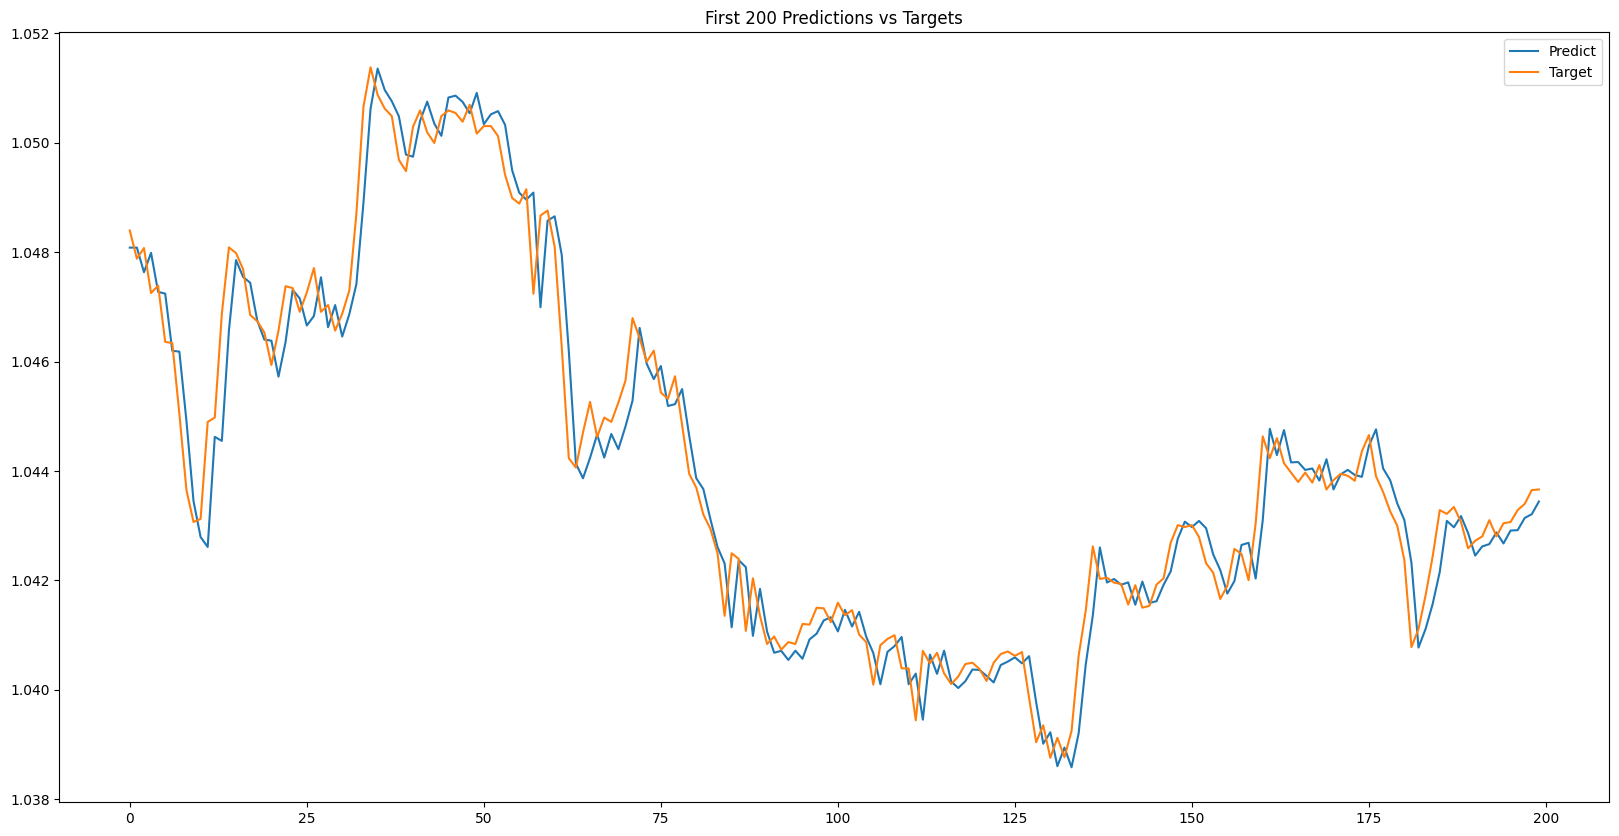

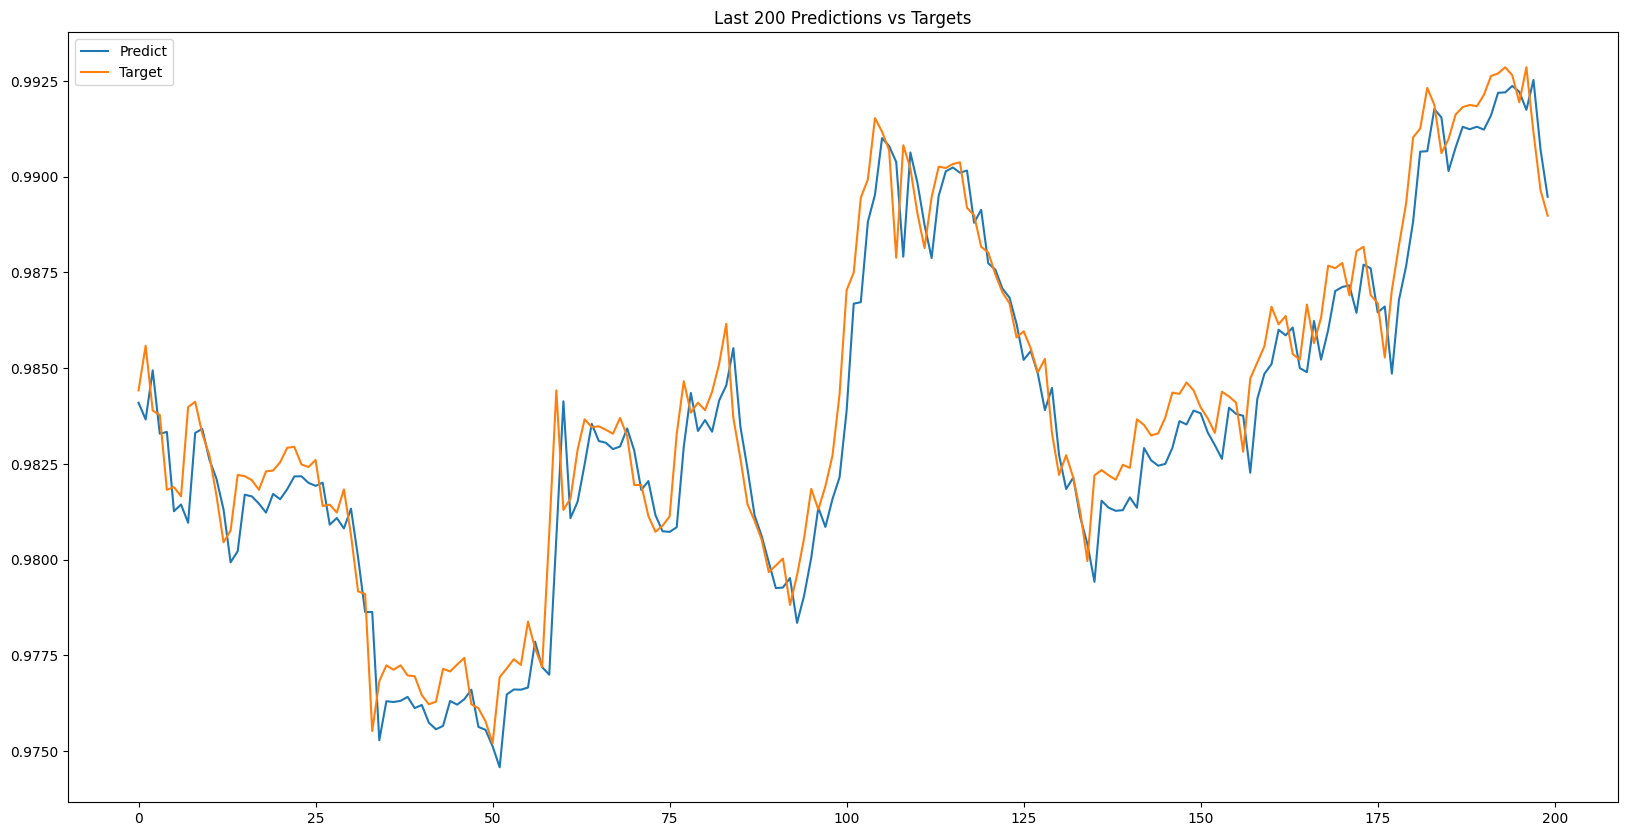

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
import sklearn.preprocessing as preprocessing
import sklearn.metrics as sm
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

def plot_predictions(targets, predictions, title='Predictions vs Targets', legend=['Predict', 'Target']):
    plt.figure(figsize=(20, 10))
    plt.plot(predictions)
    plt.plot(targets)
    plt.legend(legend)
    plt.title(title)
    plt.show()

def plot_last_values(model, X, y, num_values=1000, title='Last Values Predictions vs Targets'):
    last_values = X[-num_values:, :, :]
    predict_last_values = model.predict(last_values)
    last_values_y = y[-num_values:]

    plot_predictions(last_values_y, predict_last_values, title=title)


def evaluate_and_plot_regression_model(model, X_train, X_test, y_train, y_test, data_df):
    # Make predictions
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    # Normalize the 'Close' values
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    close11 = min_max_scaler.fit_transform(data_df['Close'].values.reshape(-1, 1))

    y_train = y_train.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))

    # Invert predictions to original scale
    trainPredict1 = min_max_scaler.inverse_transform(trainPredict)
    trainY1 = min_max_scaler.inverse_transform(y_train)
    testPredict1 = min_max_scaler.inverse_transform(testPredict)
    testY1 = min_max_scaler.inverse_transform(y_test)

    # Calculate Mean Absolute Error
    MAE1 = mean_absolute_error(trainY1, trainPredict1)
    MAE2 = mean_absolute_error(testY1, testPredict1)

    print("MAE of Train Dataset =", MAE1 * 1e4 ,'pip')
    print("MAE of Test Dataset =", MAE2 * 1e4,'pip')

    # Calculate additional metrics
    print("Mean absolute error =", sm.mean_absolute_error(testY1, testPredict1))
    print("Mean squared error =", sm.mean_squared_error(testY1, testPredict1))
    print("Median absolute error =", sm.median_absolute_error(testY1, testPredict1))
    print("Explained variance score =", sm.explained_variance_score(testY1, testPredict1))
    print("R2 score =", sm.r2_score(testY1, testPredict1))
    print("Root Mean squared error =", np.sqrt(sm.mean_squared_error(testY1, testPredict1)))

    # Plot predictions
    plot_predictions(testY1[:200], testPredict1[:200], title='First 200 Predictions vs Targets', legend=['Predict', 'Target'])
    plot_predictions(testY1[-200:], testPredict1[-200:], title='Last 200 Predictions vs Targets', legend=['Predict', 'Target'])



# Example usage:
evaluate_and_plot_regression_model(model, X_train, X_test, Y_train, Y_test, data_df)

A "pip" stands for "percentage in point" or "price interest point" in the context of forex (foreign exchange) trading. It is a standardized unit of movement in currency pairs and represents the smallest price change that can occur in the exchange rate of a currency pair. Typically, one pip is equivalent to a one-digit movement in the fourth decimal place of a currency pair's exchange rate. For example, if the EUR/USD currency pair moves from 1.1200 to 1.1201, it has experienced a one-pip movement. Pips are crucial in forex trading for measuring price changes, determining profit and loss, and setting stop-loss and take-profit levels.

Let's interpret each metric:

- **MAE of Train Dataset = 12.25 pip:**
  - The Mean Absolute Error (MAE) on the training dataset is approximately 12.25 pips.
  - MAE represents the average absolute difference between the predicted and actual values. In this context, a lower MAE indicates a better model fit to the training data.

- **MAE of Test Dataset = 12.33 pip:**
  - The Mean Absolute Error (MAE) on the test dataset is approximately 12.33 pips.
  - This measures the average absolute difference between predicted and actual values on unseen data. A similar or slightly higher MAE on the test set compared to the training set suggests the model generalizes well.

- **Mean Absolute Error = 0.0012:**
  - The mean absolute error on the normalized scale (0 to 1) is approximately 0.00123.
  - This is the average absolute difference between predicted and actual values, normalized to the scale of the target variable.

- **Mean Squared Error = 2.934e-06:**
  - The mean squared error is a very small value (in scientific notation, approximately 2.93e-06).
  - MSE measures the average of the squared differences between predicted and actual values. A smaller MSE indicates better model performance.

- **Median Absolute Error = 0.000951:**
  - The median absolute error on the normalized scale is approximately 0.00095.
  - Similar to MAE, this metric is less sensitive to outliers and represents the median absolute difference between predicted and actual values.

- **Explained Variance Score = 0.99987:**
  - The explained variance score is very close to 1 (approximately 0.9999).
  - This score indicates the proportion of variance in the target variable that the model explains. A score close to 1 suggests excellent explanatory power.

- **R2 Score = 0.99984:**
  - The R-squared score is very close to 1 (approximately 0.9998).
  - R2 measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (predictions). A score close to 1 indicates a high level of predictability.

- **Root Mean Squared Error = 0.00171:**
  - The root mean squared error on the normalized scale is approximately 0.00171.
  - RMSE is a measure of the average magnitude of the errors between predicted and actual values. A lower RMSE indicates better model performance.

In summary, these metrics collectively suggest that the model performs exceptionally well. It exhibits low errors, high explanatory power, and strong predictability on both the training and test datasets. The small values of MAE, MSE, and RMSE, along with the high R-squared and explained variance scores, indicate a robust and accurate model for predicting 1-hour EURUSD exchange rates.

# **6.Strategies for Enhancing Model Performance in EURUSD Exchange Rate Prediction**


- **Architecture Tweaks:**
  - Experiment with LSTM layer complexity, adjusting the number of layers and units.
  - Fine-tune attention mechanisms by exploring different parameters and introducing multiple layers.
  - Optimize CNN layers by adjusting filters, kernel sizes, and layer configurations.

- **Hyperparameter Tuning:**
  - Optimize learning rate to balance convergence speed and stability.
  - Explore different batch sizes to manage noise levels during training.
  - Experiment with the number of epochs to avoid underfitting or overfitting.

- **Data Preparation:**
  - Engage in feature engineering to identify additional predictors for improved predictions.
  - Explore various normalization techniques and scaling methods for preprocessing.
  - Experiment with different time step and window sizes for creating input sequences.

- **Regularization:**
  - Introduce dropout and other regularization techniques to prevent overfitting.

- **Ensemble Techniques:**
  - Consider ensemble methods to combine predictions from multiple models for enhanced performance.

- **Evaluation Metrics:**
  - Analyze model performance using diverse evaluation metrics, considering the business context.

- **Data Quality:**
  - Ensure high-quality datasets by addressing missing or inconsistent data issues.

- **Grid Search and Random Search:**
  - Conduct grid searches or random searches over hyperparameters to find optimal combinations.

- **Cross-Validation:**
  - Implement cross-validation for a more reliable estimate of model performance.

- **Model Interpretability:**
  - Utilize interpretability tools like SHAP to gain insights into model predictions and feature importance.

Monitor the impact of each adjustment carefully and maintain a comprehensive record of model performance on both training and validation datasets. These iterative strategies empower the enhancement of accuracy and robustness in predicting 1-hour EURUSD exchange rates.